<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Web Scraping Job Postings

Detailed instructions are in Readme.md 
My answers for this Project are split into several notebooks to make it easier to review key sections and make changes where needed. In 3.0, I work on building the models to answer Question 2.

## QUESTION 2: PREDICTING JOB SENIORITY LEVELS
This vague question was originally cast as finding "factors that distinguish job category".

For clarity, I'll frame it as one of predicting the seniority of a job being offered. Instead of using the four predictors used to forecast salary, this time I'll use a combined version of job responsibilities and job requirements columns to build a multi-class classifier. This make sense as both job responsibilities and job requirements in these postings address the needs of the employer, and should, in theory, give us a good sense of the seniority of the jobs involved.

There were originally 9 sub-categories for the seniority levels in my dataset. But they can be easily regrouped into three new categories for the multi-class prediction (also because I don't have enough data points to build a 9-class classifier). These are my new sub-categories for seniority levels:
- Senior level: Senior Executive, Senior Management
- Junior Level: Entry Level, Non-executive, Junior Executive
- Mid Level: Manager, Executive, Professional, Middle Management

This is a somewhat tricky multi-class problem since the majority class would be the middle management folks, who make up about 74% of the dataset. Senior management roles account for 15% of the roles on offer, while junior roles make up for about 11% of the roles in the jobs postings.

There's no specific request to predict only for senior roles, so I won't temper with the class weightage in this question in order to detect the minority classes. 

The goal here would be to find a model with the best [AUC score](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import scipy as sp
import scipy.stats as stats

from io import StringIO
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score, confusion_matrix, f1_score, mean_squared_error, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

### 1.1 DATA PREPROCESSING

In [3]:
jobs = pd.read_csv('../data/jobs_clean.csv')

In [4]:
# RE-MAPPING the target column to three levels: senior, middle and junior
jobs["Seniority_Level"] = jobs["Seniority"].map(
    {
        "Senior Executive": "Senior_Level",
        "Senior Management": "Senior_Level",
        "Manager": "Mid_Level",
        "Executive": "Mid_Level",
        "Professional": "Mid_Level",
        "Middle Management": "Mid_Level",
        "Entry Level": "Junior_Level",
        "Non-executive": "Junior_Level",
        "Junior Executive": "Junior_Level",
    }
)

In [5]:
# The jobs description and responsibilities columns are similar in many aspects and it makes sense to
#merge them in this context as a single predictor
jobs['Describe'] = jobs[['Responsibilities', 'Requirements']].apply(lambda x: ''.join(x), axis=1)

In [6]:
jobs.sample(5)

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max,Salary_Average,Seniority_Level,Describe
184,Unilite Recruitment Services,Data Management Analyst-Operations (Financial ...,Part of Operations Data Management team which...,DiplomaDegree in Finance Engineering or Compu...,Executive,Permanent,Accounting Auditing Taxation Banking and Fin...,Suntec Tower Two 9 Temasek Boulevard 038989,5000.0,8000.0,6750.0,Mid_Level,Part of Operations Data Management team which...
725,Anotech Energy Singapore,Big Data Developer,An exciting opportunity with one of our client...,Profile At least 5 years in JavaJ2EE devel...,Executive,Contract,Information Technology,Robinson 77 77 Robinson Road 068896,2000.0,7500.0,4750.0,Mid_Level,An exciting opportunity with one of our client...
168,Gfin Services (S),Product Manager,Get to know our Team Product Managers at Grab...,The must haves Product management experience ...,Professional,Permanent,Banking and Finance Information Technology,6 Battery Road 049909,5500.0,9000.0,7250.0,Mid_Level,Get to know our Team Product Managers at Grab...
611,Apl Co.,"Specialist, Ssc Process & Projects",Brief Description This position reports to the...,Education Tertiary Education Experience Min 3...,Manager,Permanent,Consulting Customer Service Information Techn...,The Metropolis 9 North Buona Vista Drive 138588,3800.0,5700.0,4750.0,Mid_Level,Brief Description This position reports to the...
566,Machspeed Human Resources,"Pre-Sales Consultant - Big Data (5 Days, Orcha...",Presales Consultant Big Data 5 days Orchard 5...,Minimum DegreeDiploma in Computer Science En...,Professional,Permanent,Information Technology,Golden Wall Centre 89 Short Street 188216,4000.0,5000.0,4500.0,Mid_Level,Presales Consultant Big Data 5 days Orchard 5...


In [7]:
df = jobs[['Seniority_Level', 'Describe']]

In [8]:
df['Seniority_Level'].value_counts()

Mid_Level       599
Senior_Level    123
Junior_Level     90
Name: Seniority_Level, dtype: int64

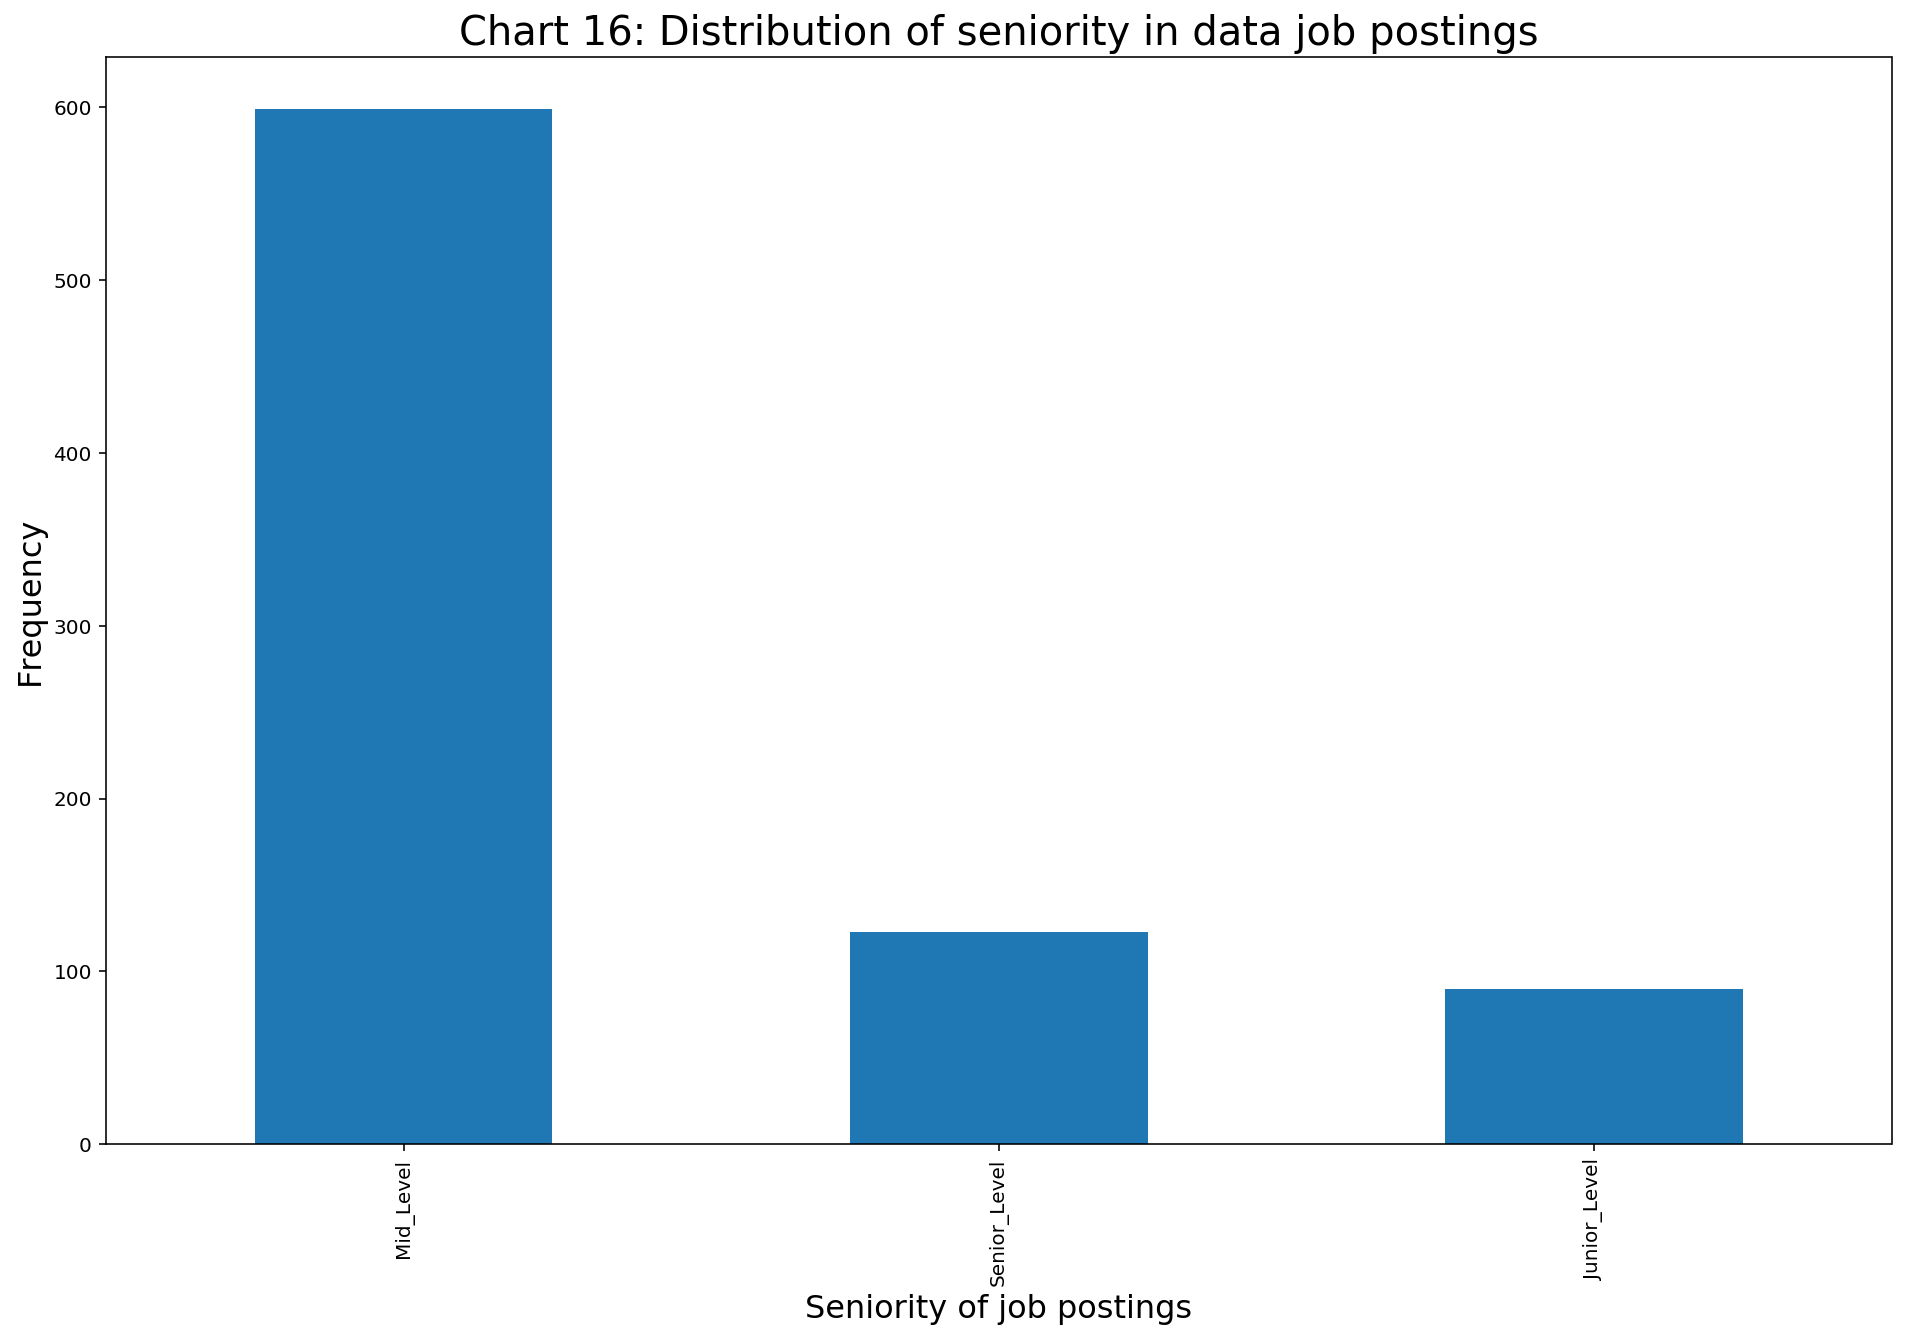

In [9]:
plt.figure(figsize=(16,10))
df['Seniority_Level'].value_counts().plot.bar()
plt.title('Chart 16: Distribution of seniority in data job postings', fontsize=20)
plt.xlabel("Seniority of job postings", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.show()

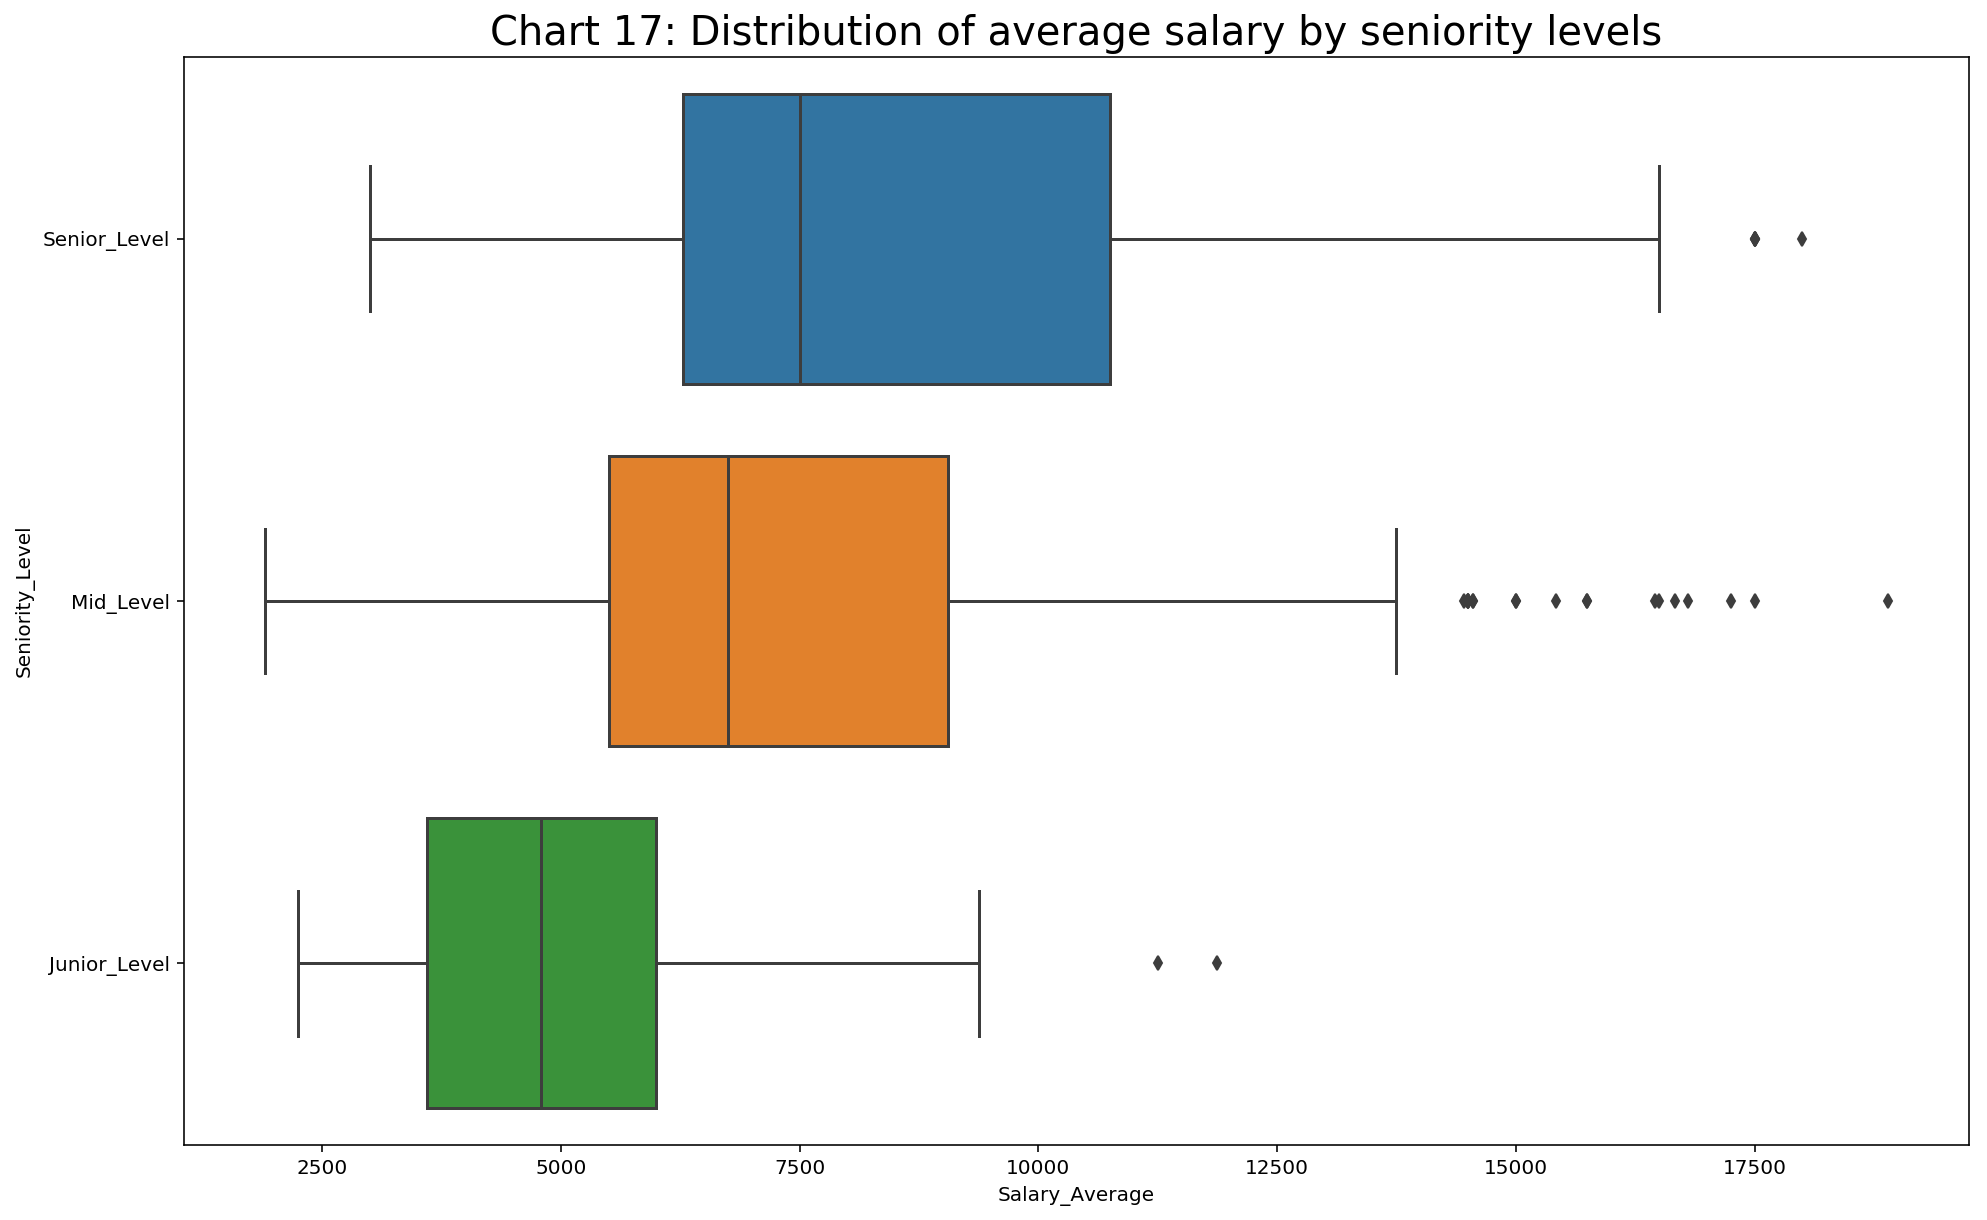

In [10]:
plt.figure(figsize=(16,10))
sns.boxplot(x="Salary_Average", y="Seniority_Level", data=jobs)
plt.title('Chart 17: Distribution of average salary by seniority levels', fontsize=20)
plt.show()

### 1.2 SPLITTING THE DATA

In [11]:
categories = ["Junior_Level", "Mid_Level", "Senior_Level"]

In [12]:
X = df['Describe']
y = df['Seniority_Level']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

In [14]:
print(X_train.shape)
print(X_test.shape)

(609,)
(203,)


In [15]:
print(y_train.shape)
print(y_test.shape)

(609,)
(203,)


### 1.3 BUILDING BASELINE PERFORMANCE VIA DUMMY CLASSIFIER

In [16]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [17]:
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [18]:
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.6305418719211823


### 1.4 SETTING A FUNCTION FOR SCORING THE MODELS
I'll try a variety of models to find out what works best. But since this is a multi-class classifier, we'll need a separate function to evaluate the models' metrics, particularly on the AUC score. The accuracy score won't suffice in this case since the models could just predict most of the "Mid_Level" class and achieve a high accuracy score while not picking up the senior or junior roles. The Precision, Recall and AUC scores would give us a better sense of which is the best model.

Code source for classification report: https://stackoverflow.com/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class/50417060#50417060

In [19]:
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [20]:
# I experimented with several combinations and found this the best fit.
# There wasn't a clear way to do gridsearch in this instance 
max_ft = 600
mindf = 2

### 1.5.1 TRY A LOGISTIC REGRESSION MODEL

In [21]:
LogReg_pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                stop_words="english", ngram_range=(1, 2), max_features=max_ft, min_df=mindf
            ),
        ),
        ("clf", OneVsRestClassifier(LogisticRegression(solver="sag"), n_jobs=-1)),
    ]
)
for category in categories:
    print("... Processing {}".format(category))

    LogReg_pipeline.fit(X_train, y_train)

    y_pred = LogReg_pipeline.predict(X_test)
    print("Test Accuracy Score :", accuracy_score(y_test, y_pred))

... Processing Junior_Level
Test Accuracy Score : 0.7093596059113301
... Processing Mid_Level
Test Accuracy Score : 0.7093596059113301
... Processing Senior_Level
Test Accuracy Score : 0.7093596059113301


In [22]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=LogReg_pipeline.predict(X_test), 
    y_score=LogReg_pipeline.predict_proba(X_test))

print(report_with_auc)

              precision    recall  f1-score  support   pred       AUC
Junior_Level   0.250000  0.043478  0.074074     23.0    4.0  0.757729
Mid_Level      0.771930  0.880000  0.822430    150.0  171.0  0.572075
Senior_Level   0.392857  0.366667  0.379310     30.0   28.0  0.597303
avg / total    0.656774  0.709360  0.672155    203.0  203.0  0.843105


### 1.5.2 TRY A RANDOM FOREST CLASSIFIER

In [23]:
RFC_pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                stop_words="english", ngram_range=(1, 2), max_features=max_ft, min_df=mindf
            ),
        ),
        (
            "clf",
            OneVsRestClassifier(
                RandomForestClassifier(
                    n_estimators=200,
                    max_depth=None,
                    max_features="auto",
                    criterion="gini",
                ),
                n_jobs=-1,
            ),
        ),
    ]
)
for category in categories:
    print("... Processing {}".format(category))

    RFC_pipeline.fit(X_train, y_train)

    y_pred = RFC_pipeline.predict(X_test)
    print("Test Accuracy Score :", accuracy_score(y_test, y_pred))

... Processing Junior_Level
Test Accuracy Score : 0.7536945812807881
... Processing Mid_Level
Test Accuracy Score : 0.7586206896551724
... Processing Senior_Level
Test Accuracy Score : 0.7536945812807881


In [24]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=RFC_pipeline.predict(X_test), 
    y_score=RFC_pipeline.predict_proba(X_test))

print(report_with_auc)

              precision    recall  f1-score  support   pred       AUC
Junior_Level   0.000000  0.000000  0.000000     23.0    1.0  0.729348
Mid_Level      0.757732  0.980000  0.854651    150.0  194.0  0.622390
Senior_Level   0.750000  0.200000  0.315789     30.0    8.0  0.687861
avg / total    0.670738  0.753695  0.678184    203.0  203.0  0.865685


### 1.5.3 TRY A GRADIENT BOOSTING CLASSIFIER

In [25]:
GBC_pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                stop_words="english", ngram_range=(1, 2), max_features=max_ft, min_df=mindf
            ),
        ),
        (
            "clf",
            OneVsRestClassifier(
                GradientBoostingClassifier(
                    learning_rate=0.1,
                    max_depth=None,
                    max_leaf_nodes=850,
                    min_samples_leaf=15,
                ),
                n_jobs=-1,
            ),
        ),
    ]
)
for category in categories:
    print("... Processing {}".format(category))

    GBC_pipeline.fit(X_train, y_train)

    y_pred = GBC_pipeline.predict(X_test)
    print("Test Accuracy Score :", accuracy_score(y_test, y_pred))

... Processing Junior_Level
Test Accuracy Score : 0.7536945812807881
... Processing Mid_Level
Test Accuracy Score : 0.7536945812807881
... Processing Senior_Level
Test Accuracy Score : 0.7536945812807881


In [26]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=GBC_pipeline.predict(X_test), 
    y_score=GBC_pipeline.predict_proba(X_test))

print(report_with_auc)

              precision    recall  f1-score  support   pred       AUC
Junior_Level   0.500000  0.043478  0.080000     23.0    2.0  0.826087
Mid_Level      0.760417  0.973333  0.853801    150.0  192.0  0.670440
Senior_Level   0.666667  0.200000  0.307692     30.0    9.0  0.729865
avg / total    0.717057  0.753695  0.685423    203.0  203.0  0.885753


### 1.5.3 TRY An XGB CLASSIFIER

In [27]:
XGB_pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                stop_words="english", ngram_range=(1, 2), max_features=max_ft, min_df=mindf
            ),
        ),
        (
            "clf",
            OneVsRestClassifier(
                XGBClassifier(
                    base_score=0.5,
                    colsample_bylevel=1,
                    colsample_bytree=1,
                    gamma=0,
                    learning_rate=0.1,
                    max_delta_step=0,
                    max_depth=10,
                    min_child_weight=2,
                    missing=None,
                    n_estimators=100,
                    reg_alpha=0,
                    objective="binary:logistic",
                    reg_lambda=1,
                    scale_pos_weight=1,
                    seed=0,
                    silent=True,
                    subsample=1,
                ),
                n_jobs=-1,
            ),
        ),
    ]
)
for category in categories:
    print("... Processing {}".format(category))

    XGB_pipeline.fit(X_train, y_train)

    y_pred = XGB_pipeline.predict(X_test)
    print("Test Accuracy Score :", accuracy_score(y_test, y_pred))

... Processing Junior_Level
Test Accuracy Score : 0.7536945812807881
... Processing Mid_Level
Test Accuracy Score : 0.7536945812807881
... Processing Senior_Level
Test Accuracy Score : 0.7536945812807881


In [28]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=XGB_pipeline.predict(X_test), 
    y_score=XGB_pipeline.predict_proba(X_test))

print(report_with_auc)

              precision    recall  f1-score  support   pred       AUC
Junior_Level   0.500000  0.043478  0.080000     23.0    2.0  0.834300
Mid_Level      0.760417  0.973333  0.853801    150.0  192.0  0.710692
Senior_Level   0.666667  0.200000  0.307692     30.0    9.0  0.755491
avg / total    0.717057  0.753695  0.685423    203.0  203.0  0.894210


### ANALYSIS:
The XGB Classifier offers the best AUC and overall scores, even though it predicts very poorly for the junior and senior levels.

If there's a business case for focusing on predicting for either the junior or senior roles, we could tune the XGB Classifier or use a simpler one like the Random Forest with class weightage.

### This is the end of the coding section for Project 4. I'm not attempting the Bonus Question.
### I'll present a summary report in Notebook 4.0.